In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '../../')

import os
os.chdir('../../')

In [29]:
from src.encode_data import *
from src.midi_data import *
from src.data_sources import process_all
from src.midi_transform import *
from src.fastai_data import *
from src.msklm import *
from src.serve import *

In [4]:
from fastai.text import *

## Example notebook explaining how to encode midi to numpy array and train with fastai

Numpy format 

In [5]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'
midi_path.mkdir(parents=True, exist_ok=True)

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'
numpy_path.mkdir(parents=True, exist_ok=True)

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

### 2. Encode midi files to numpy

For more in customized encoding - see `notebooks/dataformatting/2-DataFormatting-AllCombined-X.ipynb`

In [6]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

59628

In [7]:
def process_files(midi_file):
    output_file = Path(str(midi_file).replace(str(data_path), str(numpy_path))).with_suffix('.npy')
    if output_file.exists(): return
    output_file.parent.mkdir(parents=True, exist_ok=True)
    
    # Part 1. Compress tracks/instruments
    npenc = transform_midi(midi_file)
    if npenc is not None: np.save(output_file, npenc)

In [8]:
def transform_midi(midi_file):
    try:
        # 1. Convert file to music21 stream
        stream = file2stream(midi_file) 
        # 2. Convert to uncompressed timestep array
        chordarr = stream2chordarr(stream)
        # 3. Convert to encoded representation
        npenc = chordarr2npenc(chordarr)
        
    except Exception as e:
        print('Could not encode to file:', midi_file, e)
        return None
    
    if not is_valid_npenc(npenc, input_path=midi_file):
        return None
    
    return npenc

In [21]:
processed = process_all(process_files, midi_files[:200], timeout=50, timeout_func=None)

Sequence too short: 28 data/midi/datasets/pianoroll/w/willie-nelson/on-the-road-again/verse_key_cparallel.mid
Sequence too short: 28 data/midi/datasets/pianoroll/w/willie-nelson/on-the-road-again/verse_key_cmajor.mid
Sequence too short: 15 data/midi/datasets/pianoroll/w/weebl/donkeys/intro_key_original.mid
Sequence too short: 19 data/midi/datasets/pianoroll/w/willie-nelson/on-the-road-again/bridge_key_cmajor.mid
Sequence too short: 15 data/midi/datasets/pianoroll/w/weebl/donkeys/intro_key_cparallel.mid
Sequence too short: 19 data/midi/datasets/pianoroll/w/willie-nelson/on-the-road-again/bridge_key_cparallel.mid
Sequence too short: 28 data/midi/datasets/pianoroll/w/willie-nelson/on-the-road-again/verse_key_original.mid
Sequence too short: 19 data/midi/datasets/pianoroll/w/willie-nelson/on-the-road-again/bridge_key_original.mid
Sequence too short: 15 data/midi/datasets/pianoroll/w/weebl/donkeys/intro_key_cmajor.mid
Sequence too short: 24 data/midi/datasets/pianoroll/w/wolfgang-gartner/un

## 3. Create dataset from encoded files

In [23]:
def create_databunch(files, out_path):
    if (out_path/'tmp/train_ids.npy').exists():
        data = MusicDataBunch.load(out_path, bs=batch_size)
    else:
        ps = [OpenNPFileProcessor()]
        data = (MusicItemList(items=files, path=out_path, processor=ps)
                .split_by_rand_pct(0.01, seed=6)
                .label_const(label_cls=LMLabelList))
        data = data.databunch()
        data.save('tmp/txl')
    return data

In [24]:
numpy_files = get_files(numpy_path, '.npy', recurse=True); len(numpy_files)

182

In [25]:
data = create_databunch(numpy_files, numpy_path)

## 4. Load Model

In [36]:
data = MusicDataBunch.load(path=numpy_path)
data.vocab = vocab

In [32]:
v15_config

<function src.serve.v15_config(vocab)>

In [37]:
# Using fastai's default config and architecture
config = v15_config(vocab).copy(); config

{'ctx_len': 150,
 'n_layers': 16,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_bptt': False,
 'note_range': (9, 137),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 312}

In [50]:
config = tfmerXL_lm_config.copy(); config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 10,
 'd_model': 410,
 'd_head': 41,
 'd_inner': 2100,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.ReLU: 1>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 150,
 'mask': True}

In [47]:
argspec = inspect.getfullargspec(TransformerXL.__init__)

In [48]:
argspec

FullArgSpec(args=['self'], varargs='args', varkw='kwargs', defaults=None, kwonlyargs=[], kwonlydefaults=None, annotations={})

In [41]:
TransformerXL(**config)

TypeError: __init__() got an unexpected keyword argument 'output_p'

In [53]:
# MusicTransformerXL()
# learn = music_model_learner(data, config)

In [52]:
model = get_language_model(TransformerXL, len(vocab.itos), config=config)
learn = MusicLearner(data, model, split_func=tfmerXL_lm_split)

AttributeError: 'NoneType' object has no attribute 'get'

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.770285,1.900877,0.480995,02:19
1,1.463126,1.486999,0.572417,02:19
2,1.362965,1.380375,0.596014,02:19
3,1.279640,1.345384,0.607621,02:19


## 5. Prediction time

In [43]:
x,y = data.one_batch(cpu=False) # Load up a random batch

In [46]:
out,seed = learn.predict(x, n_words=100)

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 5 of 
[None, None, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


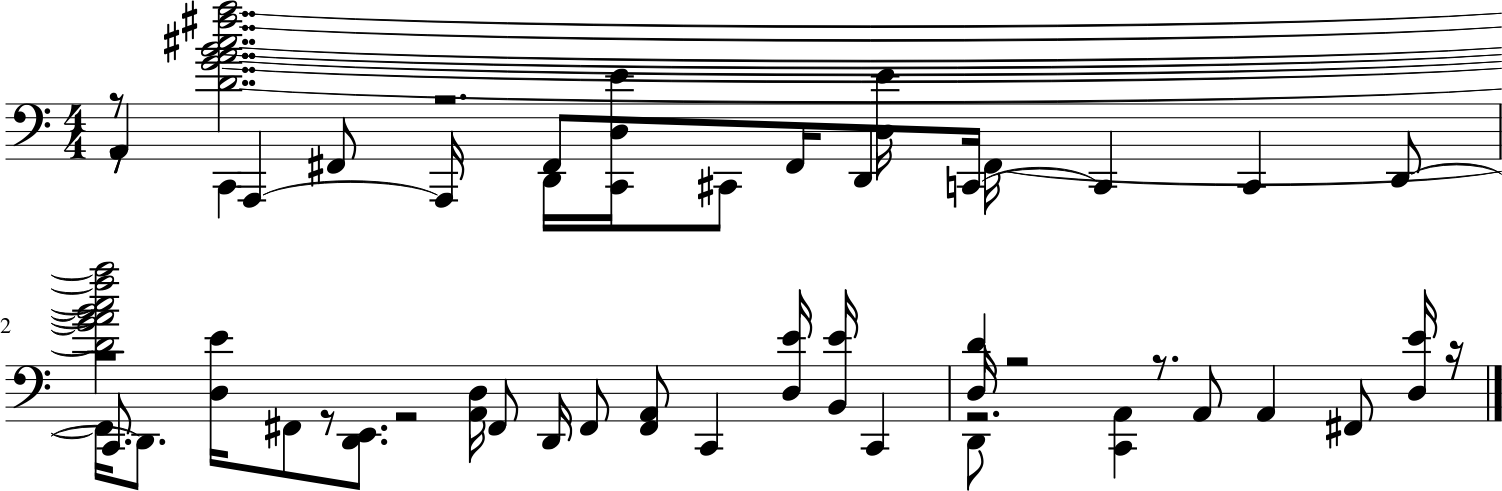

In [49]:
# Prediction
stream = npenc2stream(to_double_stream(np.concatenate([seed, out]), vocab))
stream.show()

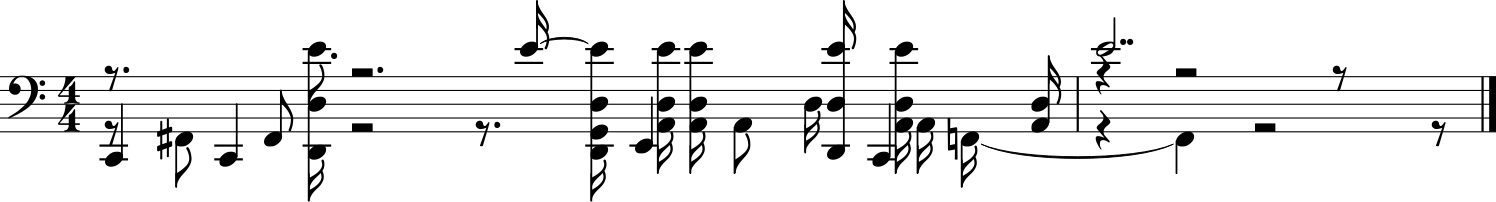

In [18]:
# Prediction
stream = npenc2stream(to_double_stream(out, vocab))
stream.show()

## 6. Predict from existing midi file

In [51]:
midi_files = get_files(data_path, '.mid', recurse=True)
midi_file = midi_files[0]; midi_file

PosixPath('data/midi/130k_reddit_midi/Jazz_www.thejazzpage.de_MIDIRip/phasedance.mid')

In [73]:
# Encode midi file to array for prediction
stream = file2stream(midi_file) 
chordarr = stream2chordarr(stream, max_dur=DUR_RANGE-2, flat=False)
seq = chordarr2seq(chordarr)
npenc = seq2npenc(seq); npenc.shape

(6926, 2)

In [75]:
# convert numpy encoding to torch tensor. 
seed_len = 100
x_inp = torch.from_numpy(to_single_stream(npenc, vocab))[:seed_len][None]
npenc.shape, x_inp.shape

((6926, 2), torch.Size([1, 100]))

In [ ]:
# heres' what the original file looks like
stream.flat.show()

In [71]:
out, seed = learn.predict(x_inp.cuda(), n_words=100)

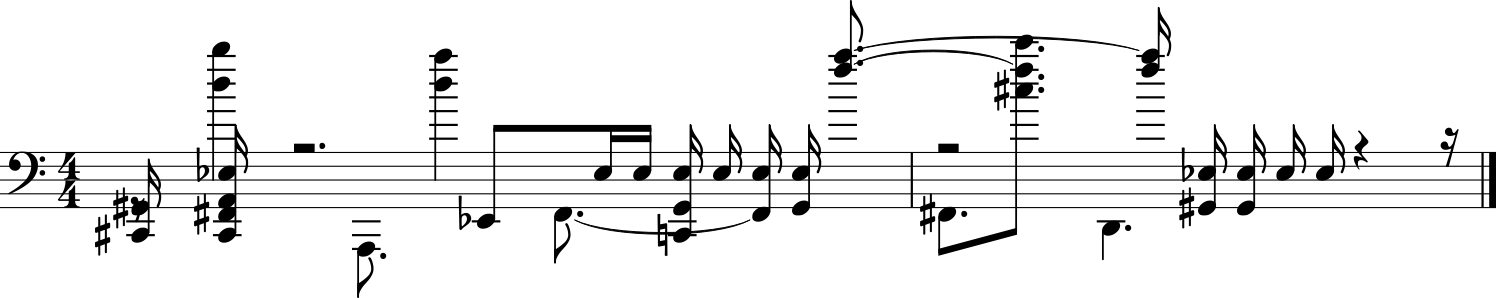

In [72]:
# Prediction
stream = npenc2stream(to_double_stream(out, vocab))
stream.show()